# Evaluate

This notebook evaluates the network trained previous notebooks and analyzes the results.

-----

## Load Packages

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%cd ..
%load_ext autoreload
%autoreload 2

C:\Users\Minjae\Desktop\EEG_Project


In [2]:
# Load some packages
import os
from copy import deepcopy
import hydra
from omegaconf import OmegaConf
from collections import OrderedDict

import numpy as np
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pprint
import matplotlib
import matplotlib.pyplot as plt

# custom package
from datasets.caueeg_script import build_dataset_for_train
import models
from train.evaluate import check_accuracy
from train.evaluate import check_accuracy_extended
from train.evaluate import check_accuracy_extended_debug
from train.evaluate import check_accuracy_multicrop
from train.evaluate import check_accuracy_multicrop_extended
from train.evaluate import calculate_confusion_matrix
from train.visualize import draw_roc_curve
from train.visualize import draw_confusion
from train.visualize import draw_class_wise_metrics
from train.visualize import draw_error_table
from train.visualize import annotate_heatmap

In [3]:
print('PyTorch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available(): print('cuda is available.')
else: print('cuda is unavailable.') 

PyTorch version: 1.11.0+cu113
cuda is available.


-----

## Load the configuration used during the train phase

In [4]:
model_pool = [{'name': 'lo88puq7'}, {'name': 'gjkysllw'}, 
              {'name': 'v301o425'}, {'name': 'lm6j0kiz'}, 
              {'name': 'jjk1coy8'}]

for model in model_pool:
    ckpt = torch.load(os.path.join(r'E:\CAUEEG\checkpoint', model['name'], 'checkpoint.pt'), map_location=device)
    
    model['model_state'] = ckpt['model_state']
    model['config'] = ckpt['config']
    model['optimizer_state'] = ckpt['optimizer_state']
    model['scheduler_state'] = ckpt['scheduler_state']
    
    print(model['name'])
    # print(model['config'])
    # print()

lo88puq7
gjkysllw
v301o425
lm6j0kiz
jjk1coy8


-----

## Load the target model

In [5]:
# model = config['generator'](**config).to(device)
for model in model_pool:
    print(model['name'])
    model['model'] = hydra.utils.instantiate(model['config']).to(device)

    if model['config'].get('ddp', False):
        model_state_ddp = deepcopy(model['model_state'])
        model_state = OrderedDict()
        for k, v in model_state_ddp.items():
            name = k[7:] # remove 'module.' of DataParallel/DistributedDataParallel
            model_state[name] = v
        model['model_state'] = model_state
        
    model['model'].load_state_dict(model['model_state'])

lo88puq7
gjkysllw
v301o425
lm6j0kiz
jjk1coy8


-----

## Evaluate the model and analyze the performance by the crop timing

### Configurations

In [6]:
repeat = 1
for model in model_pool:
    model['config'].pop('cwd', 0)
    model['config']['ddp'] = False
    model['config']['crop_timing_analysis'] = True
    model['config']['device'] = device

    #  model['config']['seq_length'] = 16000 # TODO
    #  model['config']['test_crop_multiple'] = 32 # TODO
    
    repeat = max(repeat, round(200 / model['config']['crop_multiple']))

print(repeat)

50


### Build Dataset

In [7]:
for model in model_pool:
    train_loader, val_loader, test_loader, multicrop_test_loader = build_dataset_for_train(model['config'], verbose=True)
    
    model['train_loader'] = train_loader
    model['val_loader'] = val_loader
    model['test_loader'] = test_loader
    model['multicrop_test_loader'] = multicrop_test_loader

transform: Compose(
    EegRandomCrop(crop_length=4000, length_limit=10000000, multiple=4, latency=2000, return_timing=True)
    EegDropChannels(drop_index=[20])
    EegToTensor()
)

----------------------------------------------------------------------------------------------------

transform_multicrop: Compose(
    EegRandomCrop(crop_length=4000, length_limit=10000000, multiple=8, latency=2000, return_timing=True)
    EegDropChannels(drop_index=[20])
    EegToTensor()
)

----------------------------------------------------------------------------------------------------


task config:
{'class_label_to_name': ['Normal', 'MCI', 'Dementia'],
 'class_name_to_label': {'Dementia': 2, 'MCI': 1, 'Normal': 0},
 'task_description': 'Classification of [Normal], [MCI], and [Dementia] '
                     'symptoms.',
 'task_name': 'CAUEEG-Dementia benchmark'}

 ---------------------------------------------------------------------------------------------------- 

train_dataset[0].keys():
dict_k

### Validation set

64.70588235294117
58.14285714285714
64.87394957983193
61.70168067226891
62.411764705882355


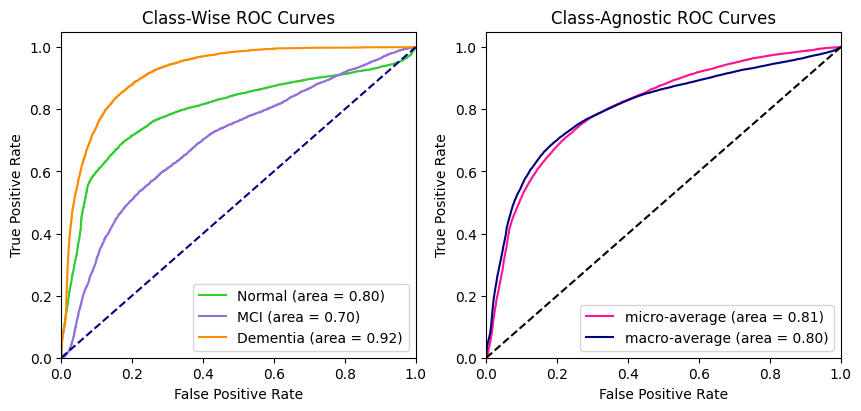

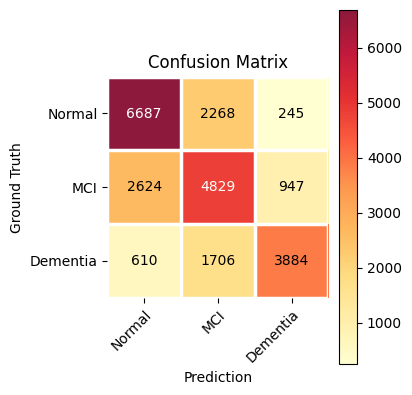

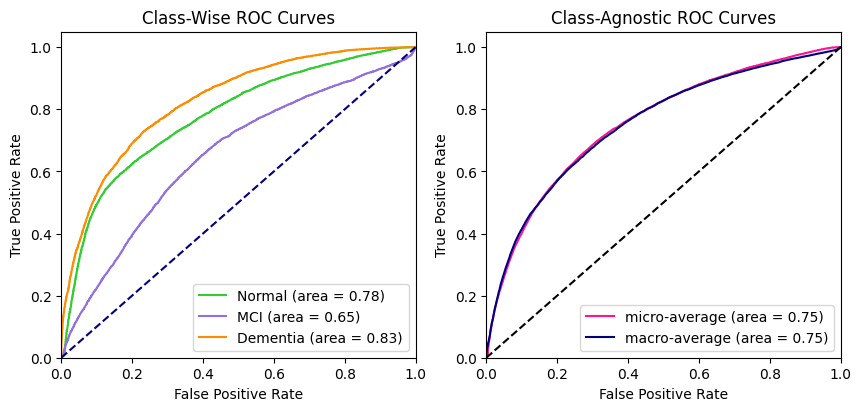

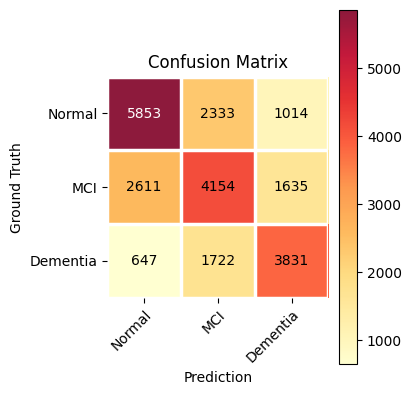

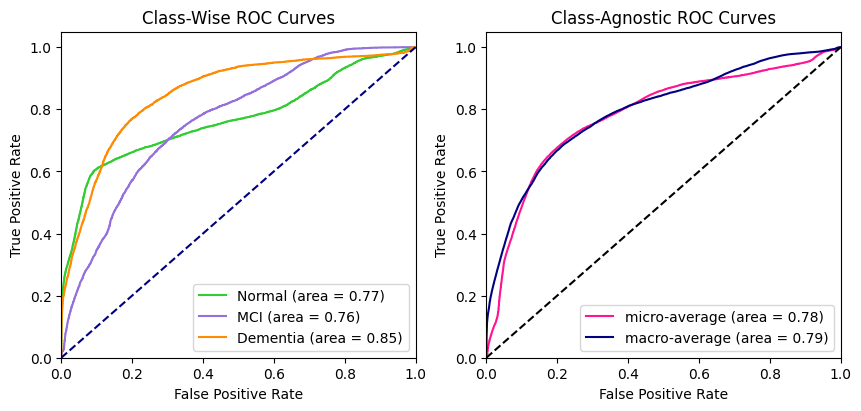

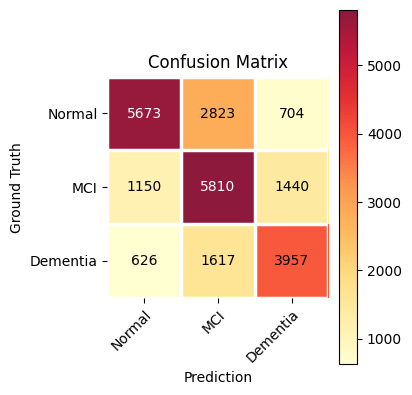

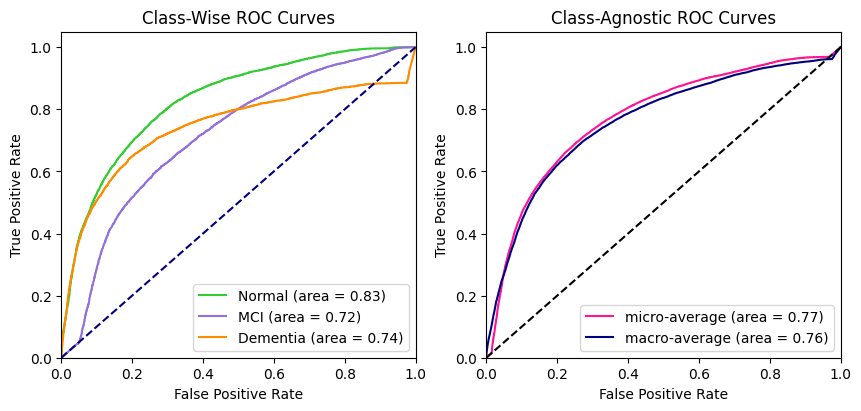

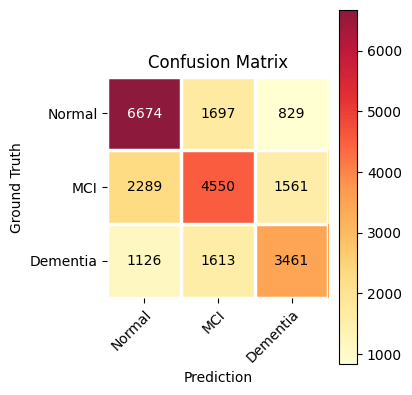

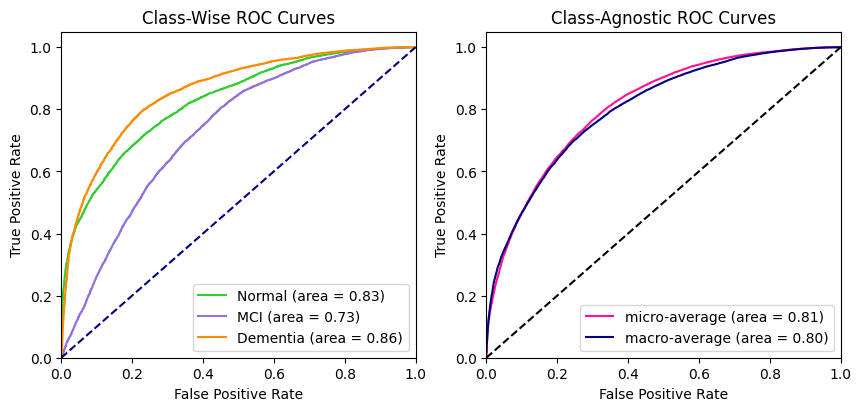

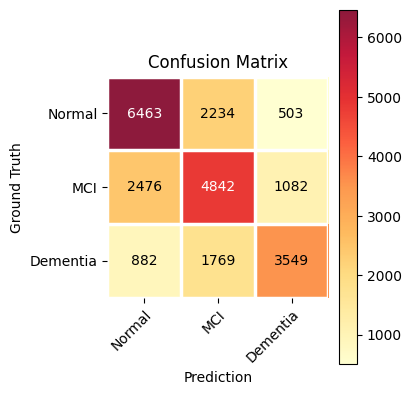

In [8]:
for model in model_pool:
    _ = check_accuracy_extended_debug(model['model'], model['val_loader'], 
                                      model['config']['preprocess_test'], model['config'], repeat=repeat)
    model['val_acc'] = _[0]
    model['val_score'] = _[1]
    model['val_target'] = _[2]
    model['val_confusion'] = _[3]
    model['val_error_table'] = _[4]
    model['val_crop_timing'] = _[5]

    print(model['val_acc'])
    
for model in model_pool:
    draw_roc_curve(model['val_score'], model['val_target'], model['config']['class_label_to_name'], use_wandb=False)
    draw_confusion(model['val_confusion'], model['config']['class_label_to_name'], use_wandb=False)

70.84033613445378


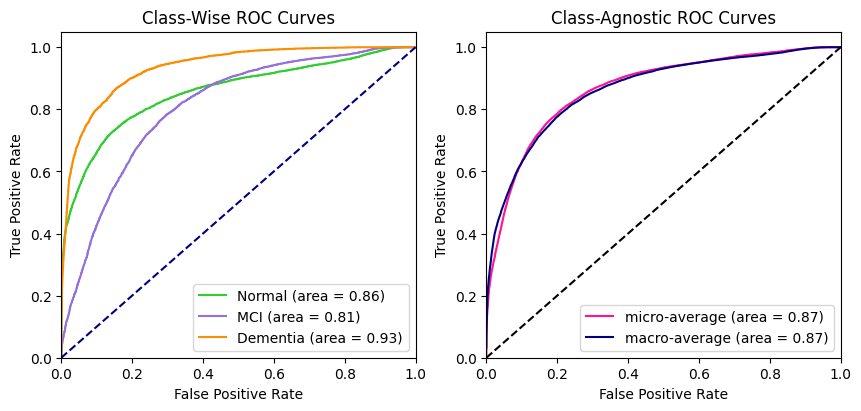

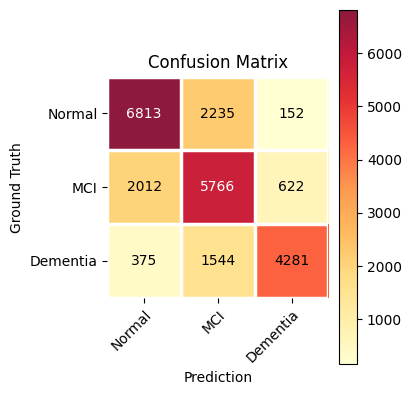

In [9]:
ensemble_val_score = np.zeros_like(model['val_score'])

for model in model_pool:
    ensemble_val_score += model['val_score'] / len(model_pool)

# accuracy
pred = ensemble_val_score.argmax(axis=-1)
ensemble_val_acc = 100.0 * (pred.squeeze() == model['val_target']).sum() / pred.shape[0]
print(ensemble_val_acc)

# confusion matrix
ensemble_val_confusion = calculate_confusion_matrix(pred, model['val_target'], 
                                                    num_classes=model['config']['out_dims'])

# draw
draw_roc_curve(ensemble_val_score, model['val_target'], model['config']['class_label_to_name'], use_wandb=False)
draw_confusion(ensemble_val_confusion, model['config']['class_label_to_name'], use_wandb=False)

### Test set

68.4364406779661
61.381355932203384
65.33474576271186
61.504237288135585
59.95338983050848


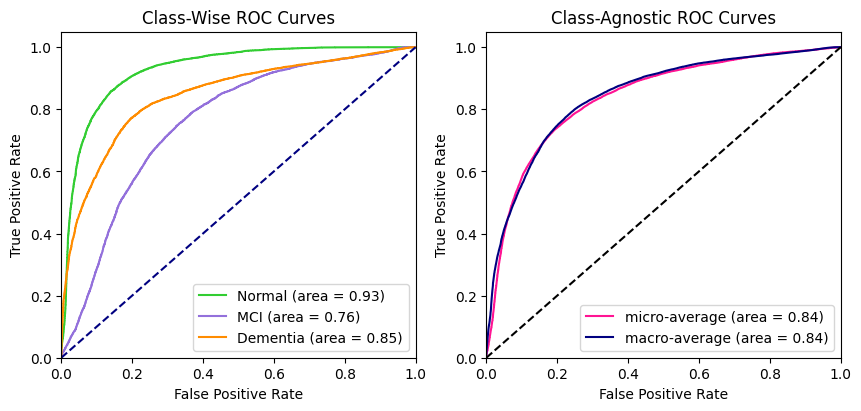

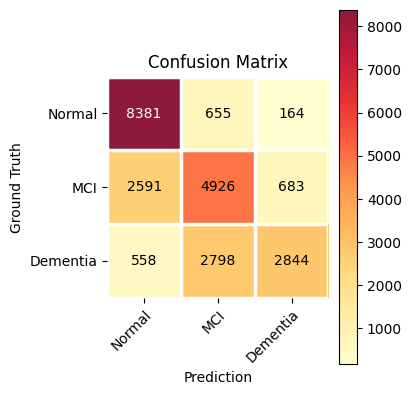

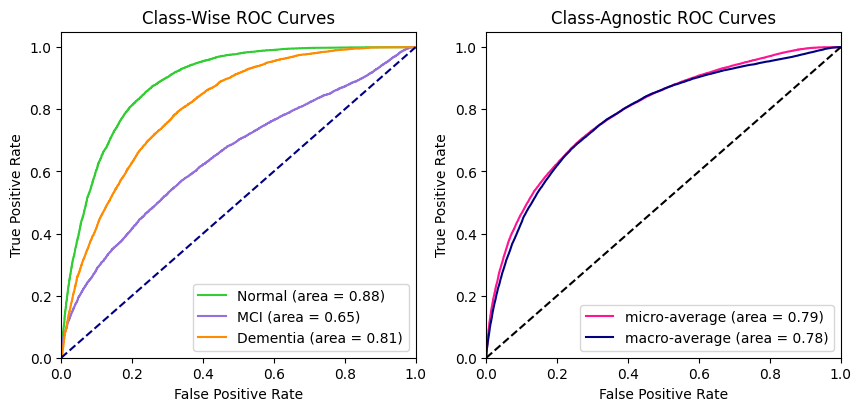

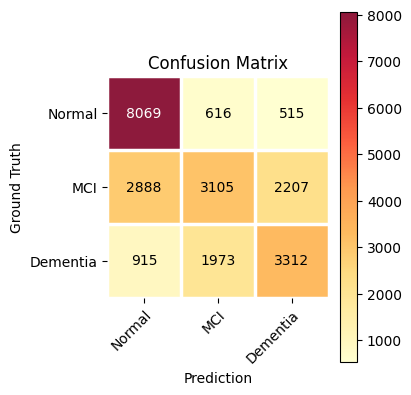

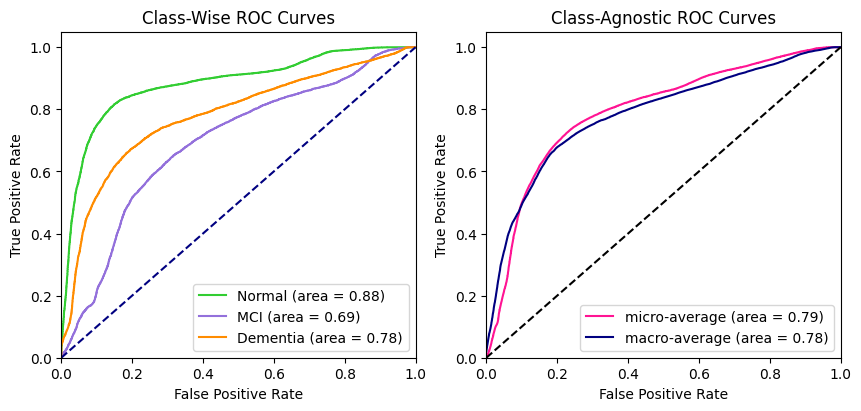

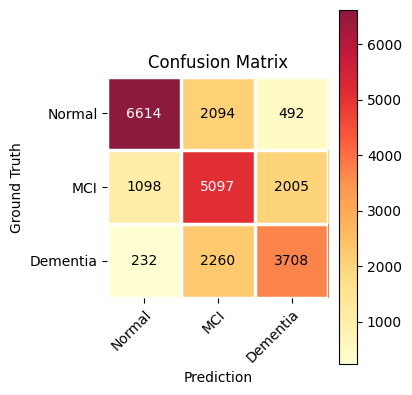

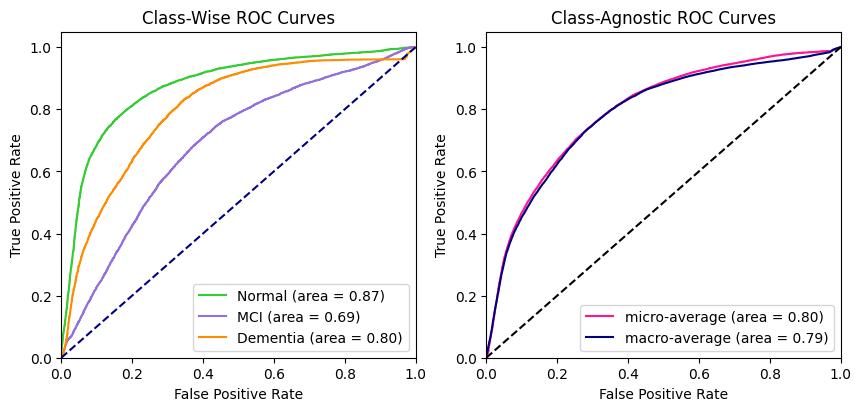

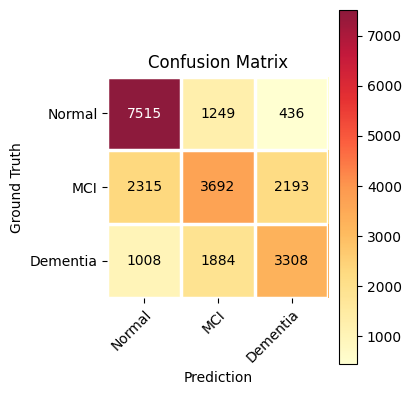

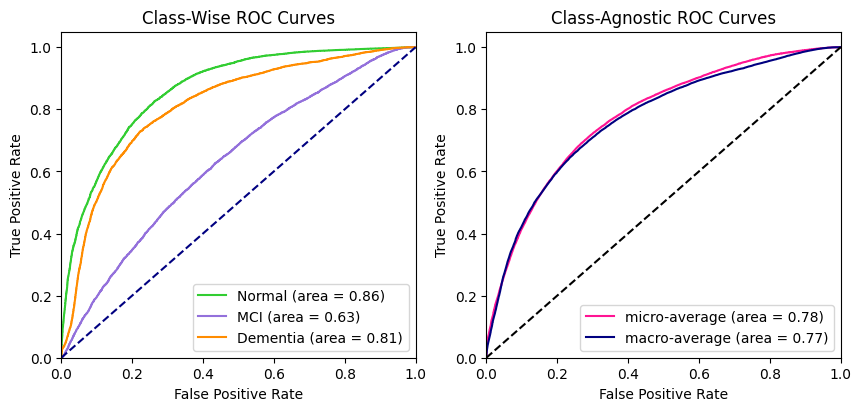

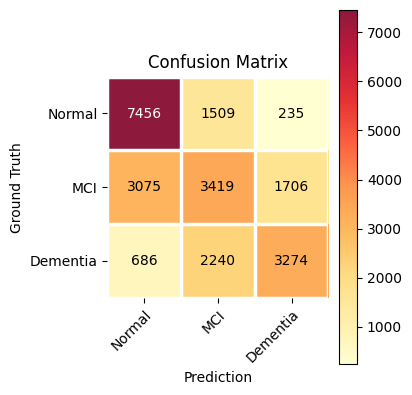

In [10]:
for model in model_pool:
    _ = check_accuracy_extended_debug(model['model'], model['test_loader'], 
                                      model['config']['preprocess_test'], model['config'], repeat=repeat)
    model['test_acc'] = _[0]
    model['test_score'] = _[1]
    model['test_target'] = _[2]
    model['test_confusion'] = _[3]
    model['test_error_table'] = _[4]
    model['test_crop_timing'] = _[5]

    print(model['test_acc'])
    
for model in model_pool:
    draw_roc_curve(model['test_score'], model['test_target'], model['config']['class_label_to_name'], use_wandb=False)
    draw_confusion(model['test_confusion'], model['config']['class_label_to_name'], use_wandb=False)

71.77966101694915


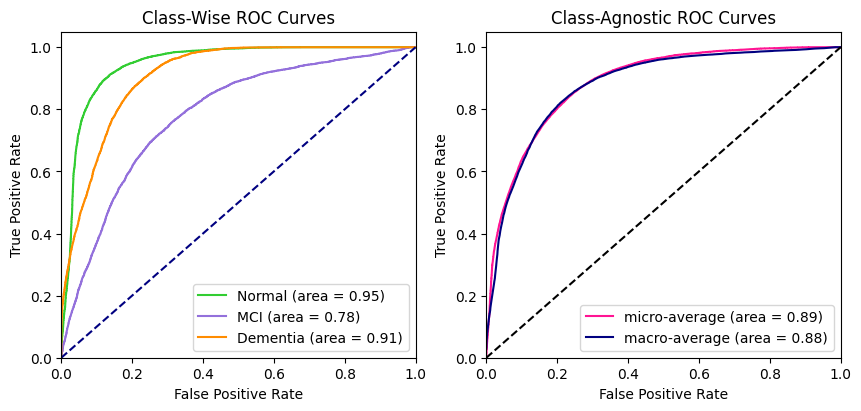

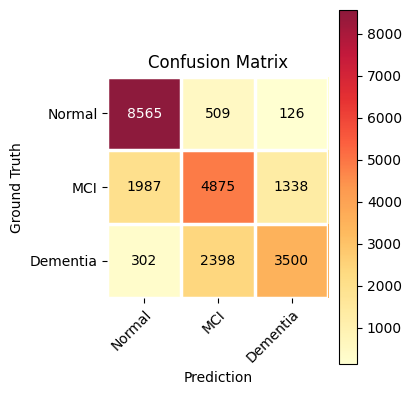

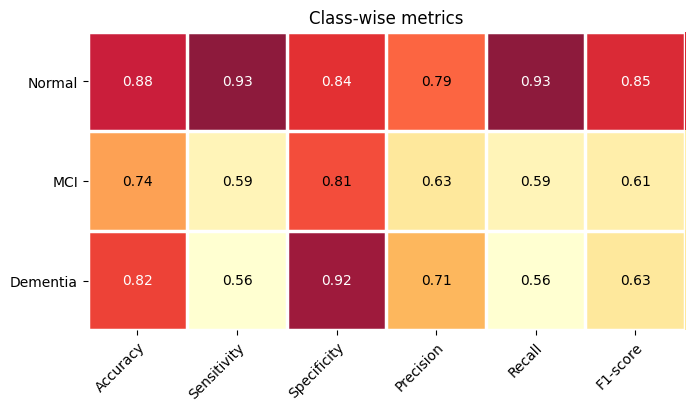

In [12]:
ensemble_test_score = np.zeros_like(model['test_score'])

for model in model_pool:
    ensemble_test_score += model['test_score'] / len(model_pool)

# accuracy
pred = ensemble_test_score.argmax(axis=-1)
ensemble_test_acc = 100.0 * (pred.squeeze() == model['test_target']).sum() / pred.shape[0]
print(ensemble_test_acc)

# confusion matrix
ensemble_test_confusion = calculate_confusion_matrix(pred, model['test_target'], 
                                                    num_classes=model['config']['out_dims'])

# draw
draw_roc_curve(ensemble_test_score, model['test_target'], model['config']['class_label_to_name'], use_wandb=False)
draw_confusion(ensemble_test_confusion, model['config']['class_label_to_name'], use_wandb=False)
draw_class_wise_metrics(ensemble_test_confusion, model['config']['class_label_to_name'], use_wandb=False)

### Test set (with test-time augmentation)

68.29872881355932
61.29025423728813
65.38771186440678
61.682203389830505
59.724576271186436


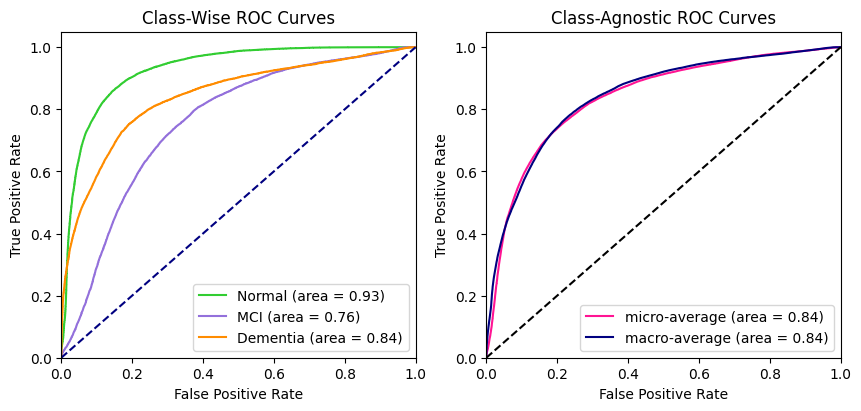

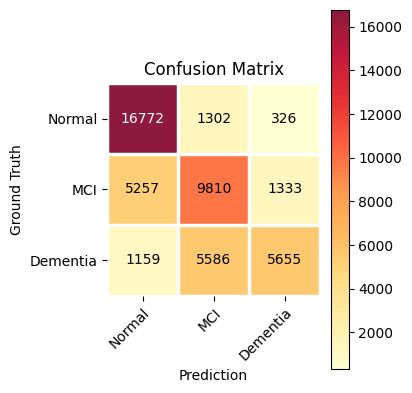

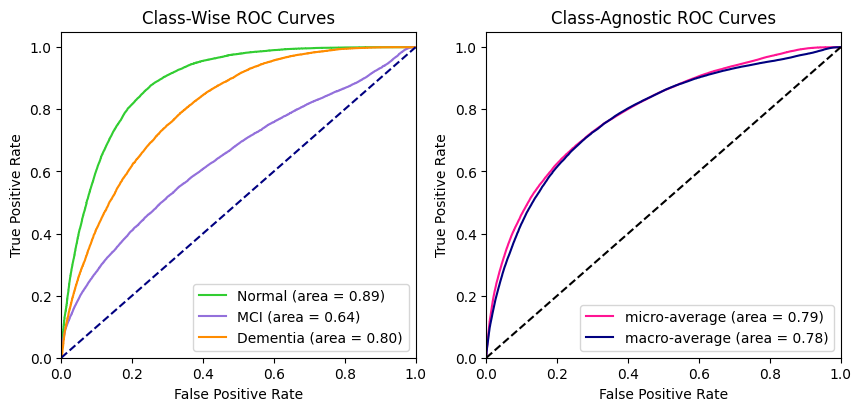

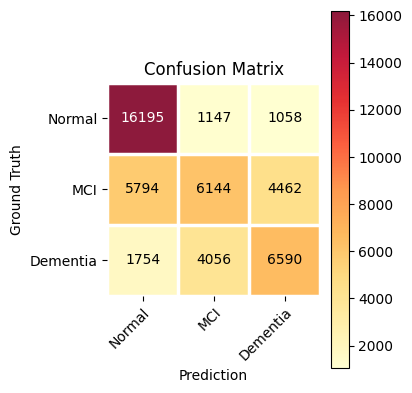

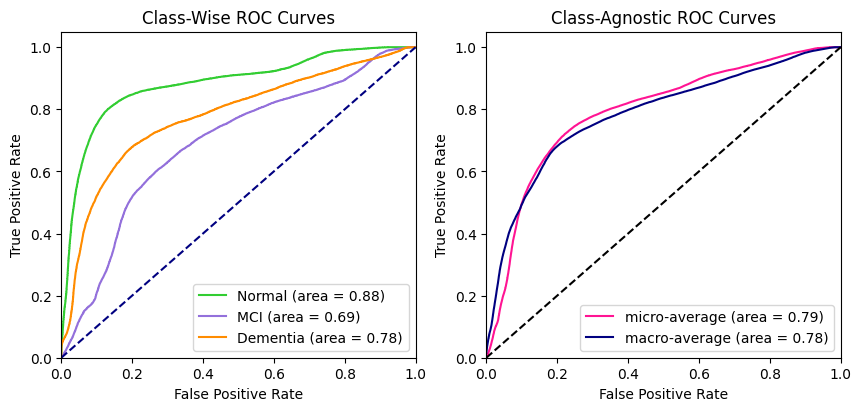

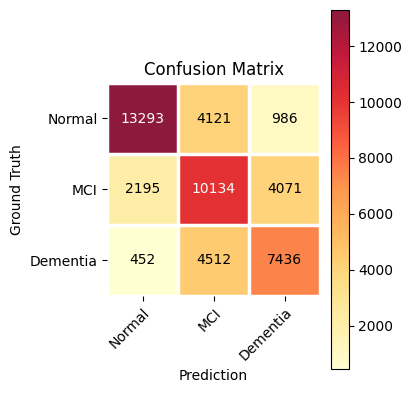

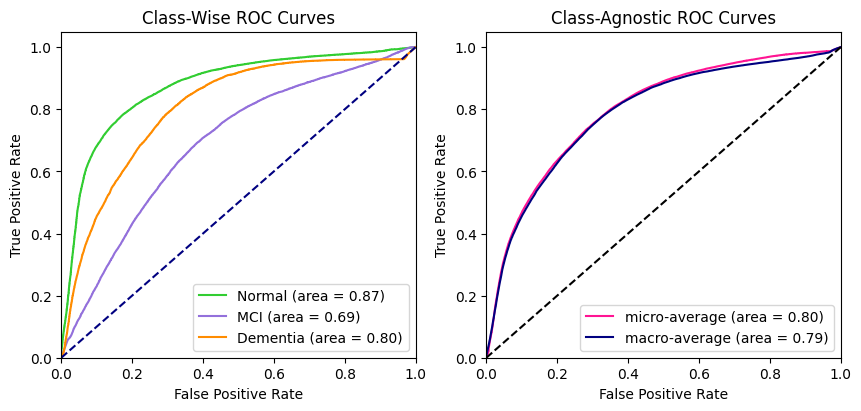

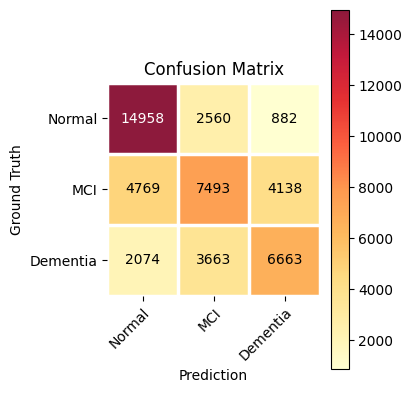

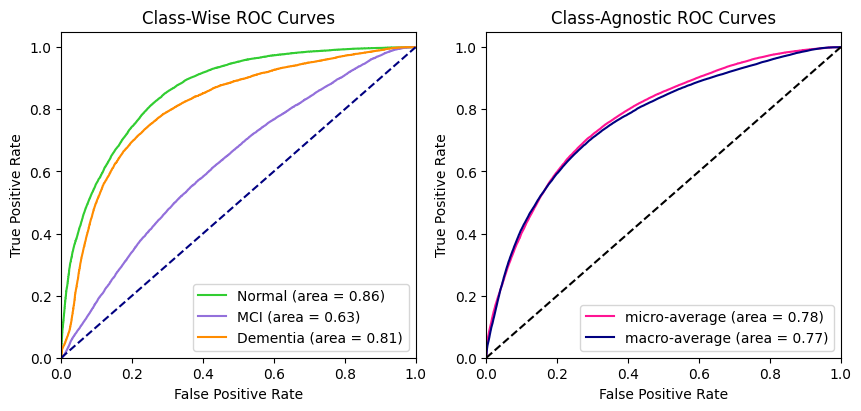

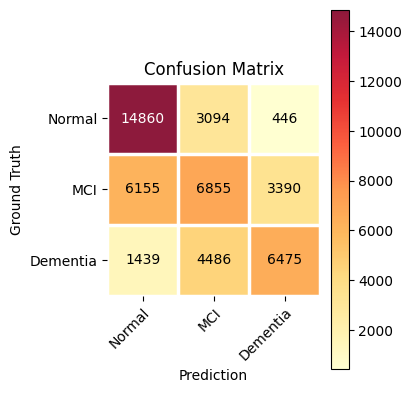

In [13]:
for model in model_pool:
    _ = check_accuracy_extended_debug(model['model'], model['multicrop_test_loader'], 
                                      model['config']['preprocess_test'], model['config'], repeat=repeat)
    model['multicrop_test_acc'] = _[0]
    model['multicrop_test_score'] = _[1]
    model['multicrop_test_target'] = _[2]
    model['multicrop_test_confusion'] = _[3]
    model['multicrop_test_error_table'] = _[4]
    model['multicrop_test_crop_timing'] = _[5]

    print(model['multicrop_test_acc'])
    
for model in model_pool:
    draw_roc_curve(model['multicrop_test_score'], model['multicrop_test_target'], model['config']['class_label_to_name'], use_wandb=False)
    draw_confusion(model['multicrop_test_confusion'], model['config']['class_label_to_name'], use_wandb=False)

71.74364406779661


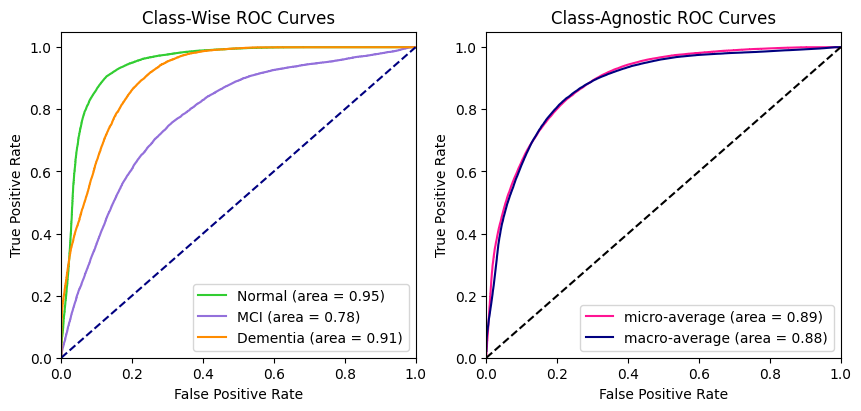

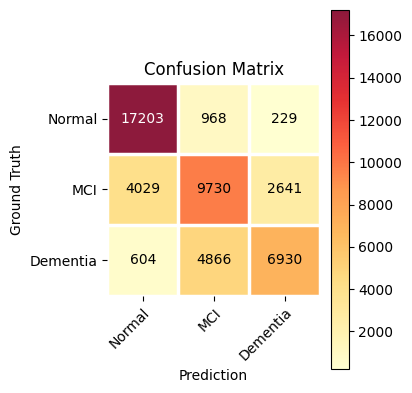

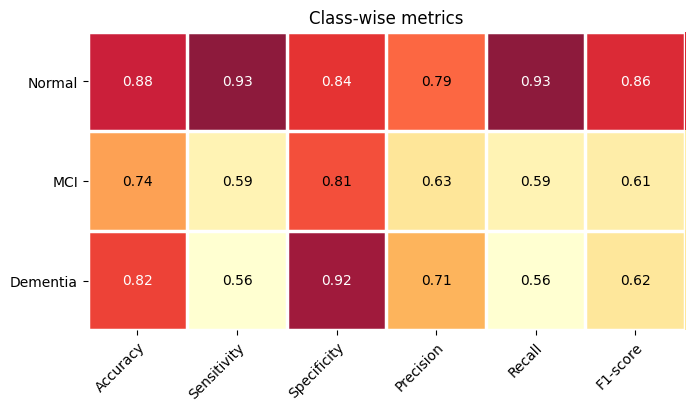

In [14]:
ensemble_multicrop_test_score = np.zeros_like(model['multicrop_test_score'])

for model in model_pool:
    ensemble_multicrop_test_score += model['multicrop_test_score'] / len(model_pool)

# accuracy
pred = ensemble_multicrop_test_score.argmax(axis=-1)
ensemble_multicrop_test_acc = 100.0 * (pred.squeeze() == model['multicrop_test_target']).sum() / pred.shape[0]
print(ensemble_multicrop_test_acc)

# confusion matrix
ensemble_multicrop_test_confusion = calculate_confusion_matrix(pred, model['multicrop_test_target'], 
                                                    num_classes=model['config']['out_dims'])

# draw
draw_roc_curve(ensemble_multicrop_test_score, model['multicrop_test_target'], model['config']['class_label_to_name'], use_wandb=False)
draw_confusion(ensemble_multicrop_test_confusion, model['config']['class_label_to_name'], use_wandb=False)
draw_class_wise_metrics(ensemble_multicrop_test_confusion, model['config']['class_label_to_name'], use_wandb=False)